In [353]:
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

import xgboost



from matplotlib import pyplot as plt
import seaborn as sns
import joblib

In [354]:
def get_evaluation(y_true,y_pred):
    score_dict={}
    score_dict['rmse']=np.round(mean_squared_error(y_true,y_pred,multioutput='raw_values',squared=False),decimals=2)
    score_dict['rmse_ave']=np.round(mean_squared_error(y_true,y_pred,multioutput='uniform_average',squared=False),decimals=2)
    score_dict['r2']=np.round(r2_score(y_true,y_pred),decimals=2)
    return score_dict

def print_evaluation(model_name:str,score_dict:dict):
    rmse_list=[]
    column_names=['H2','CO','CO2','CH4','Lower','heating value','Char yield','tar yield']
    for i in range(len(score_dict['rmse'])):
        value_str=score_dict['rmse'][i]
        rmse_list.append(f"{value_str:.2f}\t\t\t{column_names[i]}")
    rmse_str='\n\t\t\t'.join(rmse_list)
    print(f"evaluation of [ {model_name} ]\n\t- average RMSE: {score_dict['rmse_ave']}\n\t- RMSE: \n\t\t\t{rmse_str}\n\t- r2 score: {score_dict['r2']}")

In [355]:
data=pd.read_excel('data/dataBiomass_CE880.xlsx',skiprows=2,header=0).drop('Number',axis=1)
data=data[data['Superficial gas velocity']<8]

x=data.iloc[:,:8]
y=data.iloc[:,8:]


mms_x=MinMaxScaler()
mms_y=MinMaxScaler()
x_norm=mms_x.fit_transform(x)
y_norm=mms_y.fit_transform(y)

x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2)
y_test_denorm=mms_y.inverse_transform(y_test)

In [356]:
# Decision Tree
dtr=DecisionTreeRegressor()
param_grid_dtr={
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10]
}
gs_dtr=GridSearchCV(dtr,param_grid_dtr,scoring='neg_mean_squared_error')
gs_dtr.fit(x_train,y_train)
best_dtr=gs_dtr.best_estimator_
y_pred=best_dtr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
dtr_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Decision Tree',dtr_eval_dict)

evaluation of [ Decision Tree ]
	- average RMSE: 5.92
	- RMSE: 
			7.27			H2
			3.98			CO
			7.14			CO2
			2.18			CH4
			2.26			Lower
			7.02			heating value
			11.61			Char yield
	- r2 score: 0.56


In [357]:
# Random Forest
rfr=RandomForestRegressor()
param_grid_rfr={
    'n_estimators':[100,200,400],
    'max_depth':[10,20,40],
}
gs_rfr=GridSearchCV(rfr,param_grid=param_grid_rfr,scoring='neg_mean_squared_error',cv=6)
gs_rfr.fit(x_train,y_train)
# gs_rfr.best_score_
best_rfr=gs_rfr.best_estimator_
y_pred=best_rfr.predict(x_test)
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Random Forest',rfr_eval_dict)

evaluation of [ Random Forest ]
	- average RMSE: 4.98
	- RMSE: 
			5.19			H2
			3.71			CO
			6.34			CO2
			2.04			CH4
			1.88			Lower
			5.36			heating value
			10.31			Char yield
	- r2 score: 0.69


In [358]:
gs_rfr.best_params_

{'max_depth': 20, 'n_estimators': 400}

In [359]:
# XGBoost
params = {
    'max_depth': 20,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',  # 多分类问题
    'random_state':None
}
y_pred_total=[]
for i in range(7):
    train_DM=xgboost.DMatrix(data=x_train,label=y_train[:,i])
    test_DM=xgboost.DMatrix(data=x_test,label=y_test[:,i])
    bst=xgboost.train(params,train_DM,num_boost_round=200)
    y_pred=bst.predict(test_DM).reshape(-1,1)
    y_pred_total.append(y_pred)
y_pred=np.concatenate(y_pred_total,axis=1)
y_pred_denorm=mms_y.inverse_transform(y_pred)
xgb_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('XGBoost',xgb_eval_dict)

evaluation of [ XGBoost ]
	- average RMSE: 4.39
	- RMSE: 
			3.71			H2
			3.43			CO
			4.66			CO2
			2.05			CH4
			2.23			Lower
			5.67			heating value
			8.97			Char yield
	- r2 score: 0.71


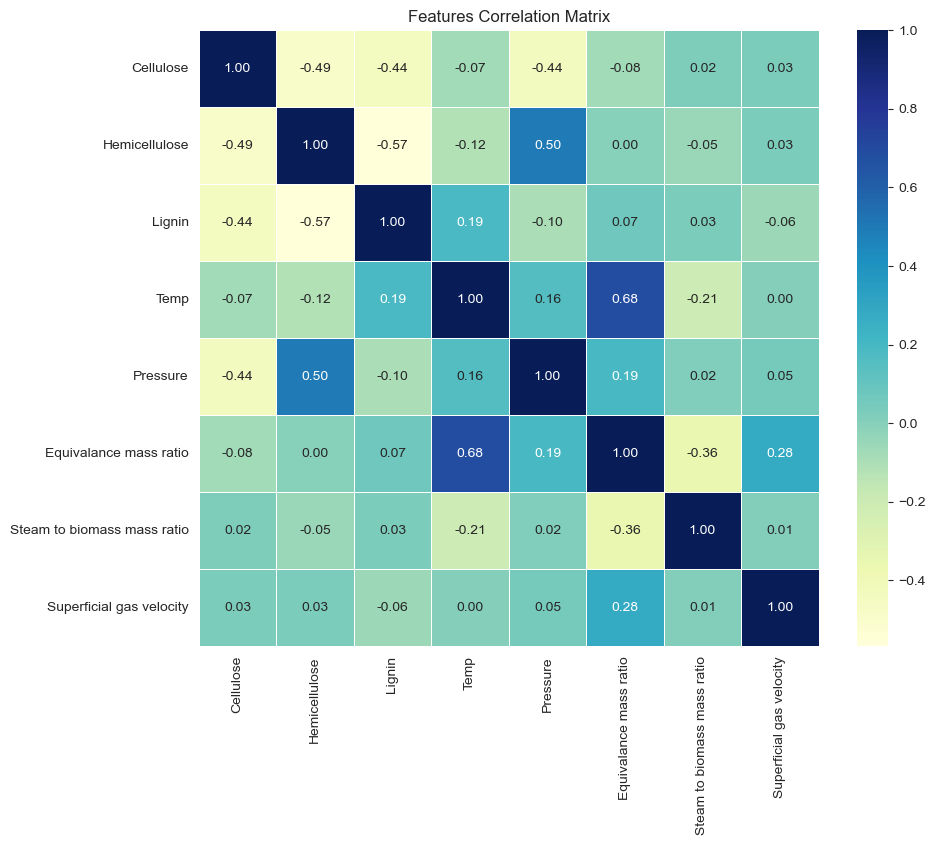

In [360]:
corr_matrix_feature=data.iloc[:,:8].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_feature,cmap='YlGnBu',annot=True,linewidths=0.5,fmt='.2f')
plt.title('Features Correlation Matrix')
plt.show()

In [361]:
# Fully-Connected Neural Network
import NeuralNetwork
from importlib import reload
reload(NeuralNetwork)
from NeuralNetwork import MLPBiomass,BiomassDataset


import torch
from torch.utils.data import DataLoader

from torch.nn import MSELoss,init
from torch.optim import Adam,SGD,Adagrad,AdamW,RMSprop
data_train=np.concatenate([x_train,y_train],axis=1)
data_test=np.concatenate([x_test,y_test],axis=1)
tensor_data_train=torch.tensor(data_train,dtype=torch.float32)
tensor_data_test=torch.tensor(data_test,dtype=torch.float32)
nn_model=MLPBiomass(8,7)

for layer in nn_model.modules():
    if isinstance(layer,torch.nn.Linear):
        init.xavier_normal(layer.weight)

dataset=BiomassDataset(tensor_data_train)

n_epochs=2000

batch_size=32
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=False)

criterion=MSELoss()
optimizer=AdamW(nn_model.parameters(),lr=0.0004)
# optimizer=SGD(nn_model.parameters(),lr=0.004,momentum=0.8)

best_epoch=None
best_score=float('inf')
best_rmse=None
best_model=None

for epoch in range(n_epochs):
    # training    
    nn_model.train()
    for batch,batch_data in enumerate(dataloader):
        optimizer.zero_grad()
        feat,label=batch_data[:,:8],batch_data[:,8:]
        pred=nn_model(feat)
        loss=criterion(pred,label)
        
        loss.backward()
        optimizer.step()
    
    # validation
    tensor_x_test=tensor_data_test[:,:8]
    tensor_y_test=tensor_data_test[:,8:]
    
    pred_test=nn_model(tensor_x_test)
    pred_test_denorm=mms_y.inverse_transform(pred_test.detach().numpy())
    nn_rmse=mean_squared_error(y_test_denorm,pred_test_denorm,multioutput='raw_values',squared=False)
    nn_rmse_mean=np.mean(nn_rmse)
    
    if epoch%100==0:
        print(f'epoch:{epoch} - test score: {nn_rmse_mean:.2f}')
        
    if nn_rmse_mean<best_score:
        best_epoch=epoch
        best_score=nn_rmse_mean
        best_rmse=nn_rmse
        best_model=nn_model.state_dict()
        
last_model=nn_model.state_dict()
        
print(f'Best performance on the test set occurred:\nepoch: {best_epoch}/{n_epochs}, score: {best_score}, rmse: {best_rmse}')

C:\Users\zekon\AppData\Local\Temp\ipykernel_10832\825788372.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(layer.weight)


epoch:0 - test score: 54.46
epoch:100 - test score: 11.50
epoch:200 - test score: 9.38
epoch:300 - test score: 7.75
epoch:400 - test score: 7.45
epoch:500 - test score: 6.52
epoch:600 - test score: 6.23
epoch:700 - test score: 6.14
epoch:800 - test score: 6.57
epoch:900 - test score: 6.00
epoch:1000 - test score: 6.18
epoch:1100 - test score: 6.02
epoch:1200 - test score: 6.00
epoch:1300 - test score: 5.96
epoch:1400 - test score: 5.60
epoch:1500 - test score: 5.55
epoch:1600 - test score: 5.26
epoch:1700 - test score: 5.33
epoch:1800 - test score: 5.23
epoch:1900 - test score: 5.25
Best performance on the test set occurred:
epoch: 1976/2000, score: 4.958898604426283, rmse: [3.68009346 5.14475625 5.57921829 1.77164824 2.43029874 6.30077475
 9.8055005 ]


In [362]:
nn_model.load_state_dict(best_model)
# nn_model.load_state_dict(last_model)
# nn_model=MLPBiomass(8,7)

y_pred=nn_model(torch.tensor(x_test,dtype=torch.float32))
y_pred_denorm=mms_y.inverse_transform(y_pred.detach().numpy())
nn_eval_dict=get_evaluation(y_test_denorm,y_pred_denorm)
print_evaluation('Fully-Connected Neural Network',nn_eval_dict)

evaluation of [ Fully-Connected Neural Network ]
	- average RMSE: 5.18
	- RMSE: 
			4.23			H2
			4.93			CO
			5.90			CO2
			1.80			CH4
			2.34			Lower
			6.50			heating value
			10.59			Char yield
	- r2 score: 0.61


In [363]:
import pickle 

with open('best_rfr.pkl','wb') as f:
    pickle.dump(best_rfr,f)

In [364]:
print_evaluation('Random Forest',rfr_eval_dict)
print('-'*150)
print_evaluation('XGBoost',xgb_eval_dict)
print('-'*150)
print_evaluation('Fully-Connected Neural Network',nn_eval_dict)


evaluation of [ Random Forest ]
	- average RMSE: 4.98
	- RMSE: 
			5.19			H2
			3.71			CO
			6.34			CO2
			2.04			CH4
			1.88			Lower
			5.36			heating value
			10.31			Char yield
	- r2 score: 0.69
------------------------------------------------------------------------------------------------------------------------------------------------------
evaluation of [ XGBoost ]
	- average RMSE: 4.39
	- RMSE: 
			3.71			H2
			3.43			CO
			4.66			CO2
			2.05			CH4
			2.23			Lower
			5.67			heating value
			8.97			Char yield
	- r2 score: 0.71
------------------------------------------------------------------------------------------------------------------------------------------------------
evaluation of [ Fully-Connected Neural Network ]
	- average RMSE: 5.18
	- RMSE: 
			4.23			H2
			4.93			CO
			5.90			CO2
			1.80			CH4
			2.34			Lower
			6.50			heating value
			10.59			Char yield
	- r2 score: 0.61
